# Car Object Detection

### Setup for yolo object detection

In [ ]:
!pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15978, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 15978 (delta 89), reused 118 (delta 76), pack-reused 15831
Receiving objects: 100% (15978/15978), 14.61 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (10958/10958), done.


In [ ]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


### Import all dependencies

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import shutil as sh
import matplotlib.pyplot as plt

### Load and Process the co-ordinates

get this dataset from kaggle and store it in data folder.<br>
https://www.kaggle.com/datasets/sshikamaru/car-object-detection

In [ ]:
df = pd.read_csv("data/train_solution_bounding_boxes (1).csv")
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
img_h, img_w, num_channels = (380, 676, 3)

# change column name
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

# preprocess the data for yolo object detection
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['status'] = 1

# scale the data
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h

df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes,status
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0,1
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0,1
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0,1
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0,1
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0,1


In [ ]:
df.image_id.nunique()

355

In [ ]:
df[['xmin', 'ymin', 'xmax', 'ymax']] =  np.divide(df[['xmin', 'ymin', 'xmax', 'ymax']], [380, 676, 380, 676])

In [ ]:
def display_image(image, boxes=[]):
  for box in boxes:
    assert len(box) == 4
    xmin, ymin, xmax, ymax = box
    image = cv2.rectangle(image,
                        tuple(np.multiply([xmin, ymin], [380, 676]).astype(int)),
                        tuple(np.multiply([xmax, ymax], [380, 676]).astype(int)),
                        (0, 255, 0), 3)

  plt.imshow(image)
  plt.axis("off")

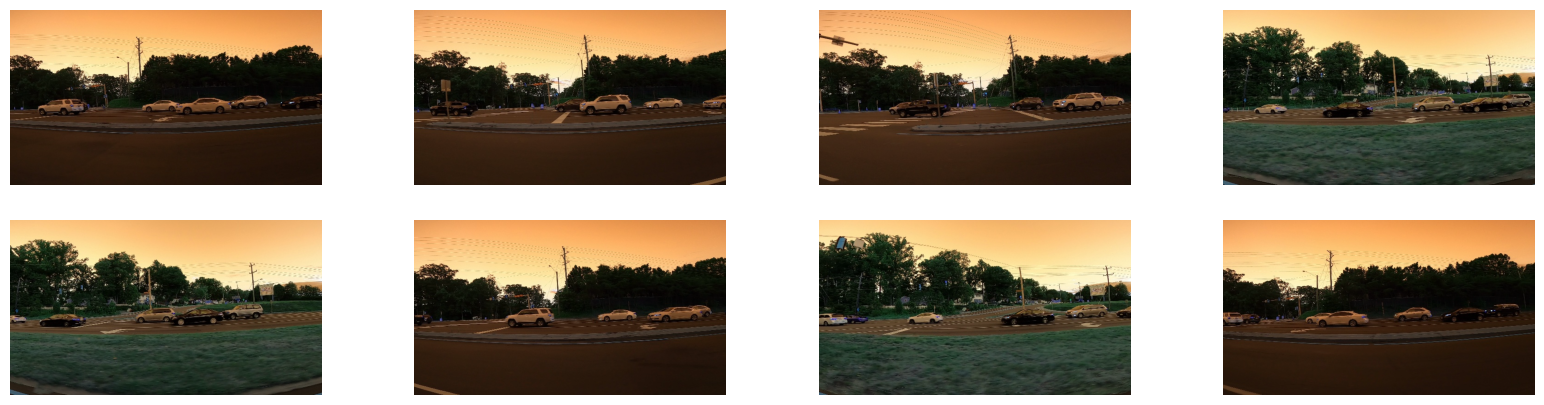

In [ ]:
ids = df.groupby('image_id').status.sum().sort_values().tail(8)

plt.figure(figsize=(20, 5))
for idx, id in enumerate(ids.index):
  plt.subplot(2, 4, idx+1)
  image = cv2.imread('data/training_images/{}.jpg'.format(id))
  plt.imshow(image)
  plt.axis('off')

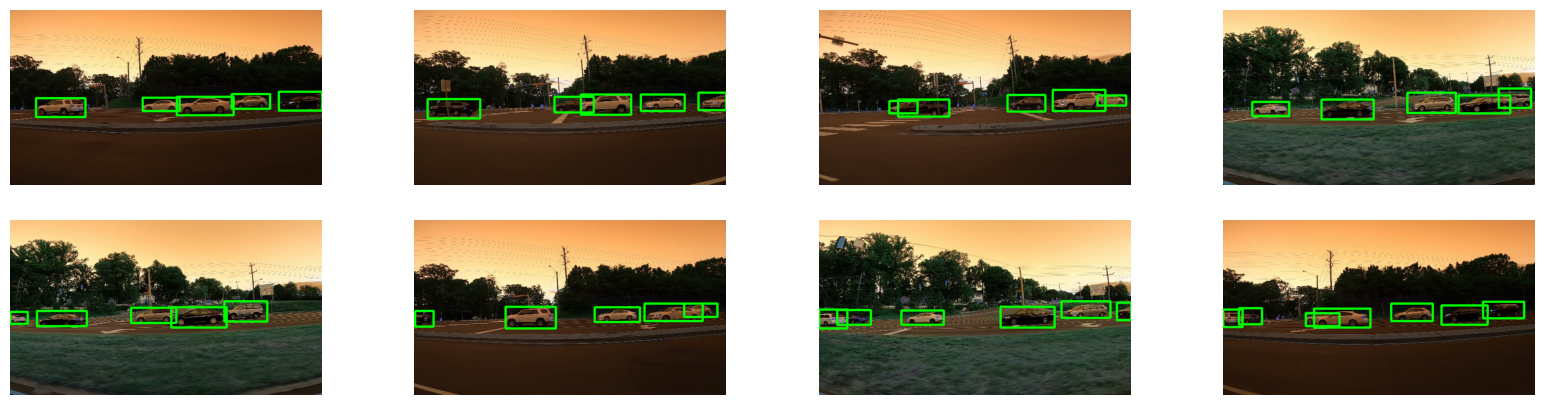

In [ ]:
ids = df.groupby('image_id').status.sum().sort_values().tail(8)

plt.figure(figsize=(20, 5))
for idx, id in enumerate(ids.index):
  plt.subplot(2, 4, idx+1)
  image = cv2.imread('data/training_images/{}.jpg'.format(id))
  boxes = df.loc[df['image_id'] == id].values[:, 1:5]
  display_image(image, boxes)

### Convert the bouding box co-ordinates to yolo format

In [ ]:
BASE_DIR = os.path.join('content', )

if not os.path.exists(os.path.join('mydata', 'images')):
  os.makedirs(os.path.join('mydata', 'images'))

if not os.path.exists(os.path.join('mydata', 'labels')):
  os.makedirs(os.path.join('mydata', 'labels'))

for idx, data in df.groupby('image_id'):
  row = data[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
  row = row.astype(str)

  with open('mydata/labels/{}.txt'.format(idx), 'w+') as f:
    for i in range(len(row)):
      text = ' '.join(row[i])
      f.write(text)
      f.write('\n')

  sh.copy('data/training_images/{}.jpg'.format(idx), 'mydata/images/{}.jpg'.format(idx))

In [ ]:
len(os.listdir(os.path.join('mydata', 'labels')))

355

### Train yolo on the dataset

before training the model, create a dataset.yaml file in yolov5 folder.

In [ ]:
!cd yolov5 & python train.py --img 676 --batch 16 --epochs 10 --data dataset.yaml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,

In [ ]:
cd ..

/content


### Load the model and detect cars

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp/weights/last.pt', force_reload=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-6-13 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
img = os.path.join('mydata', 'images', 'vid_4_26460.jpg')
results = model(img)
results.print()

image 1/1: 380x676 8 cars
Speed: 12.1ms pre-process, 8.0ms inference, 1.4ms NMS per image at shape (1, 3, 384, 640)


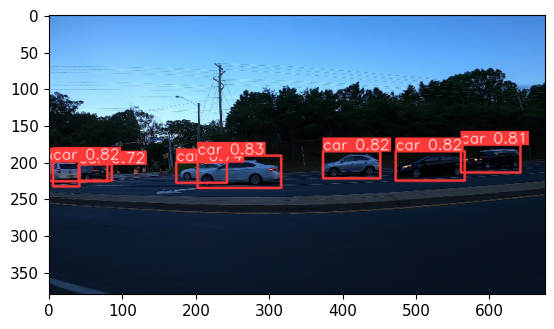

In [ ]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()